In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

In [2]:
## DATA
# Import/Load
data = pd.read_csv('../app/data/total.csv')

    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [3]:
#  Examine
data.head(5)

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...


In [4]:
data[data.location == 'Remote'].head(5)

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
6,TechTrueUP,Description: DATA SCIENTIST*** Fully remote***...,NaN,2022-04-13,"['Full-time', 'Contract']",Remote,PostedJust posted,3.8,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Bachelor's (Required)Python: 1 year (Required)...,NaN,$60 - $70 an hour,"$60 - $70 an hour - Full-time, Contract",$60 - $70 an hour,DSC is seeking a Data Scientist who would be f...,MCS Data Scientist,https://www.indeed.com/company/TechTrueUP/jobs...
9,Redfin,This position is a remote eligible position...,NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.4,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$87,600 - $131,400 a year","$87,600 - $131,400 a year - Full-time","$87,600 - $131,400 a year","Experience in analytics of operations, specifi...",Senior Data Analyst - Tour Support (Remote Eli...,https://www.indeed.com/rc/clk?jk=25a64fbe8a600...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1485 non-null   object 
 1   description       1485 non-null   object 
 2   estimated_salary  671 non-null    object 
 3   extractDate       1485 non-null   object 
 4   job_type_items    348 non-null    object 
 5   location          1485 non-null   object 
 6   postDate          1485 non-null   object 
 7   rating            1019 non-null   float64
 8   raw_desc_soup     1485 non-null   object 
 9   requirements      185 non-null    object 
 10  sal_guide_items   738 non-null    object 
 11  salary            434 non-null    object 
 12  salary_and_jType  1002 non-null   object 
 13  salfromsection    433 non-null    object 
 14  summary           1485 non-null   object 
 15  title             1485 non-null   object 
 16  url               1485 non-null   object 


In [6]:
# Missing Values?
missing_values = data.isnull().sum()
print(missing_values)

company                0
description            0
estimated_salary     814
extractDate            0
job_type_items      1137
location               0
postDate               0
rating               466
raw_desc_soup          0
requirements        1300
sal_guide_items      747
salary              1051
salary_and_jType     483
salfromsection      1052
summary                0
title                  0
url                    0
dtype: int64


In [7]:
data[data.isnull().any(axis=1)]
# every column has nulls!

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,Holland America Line,Job Description Welcome to Holland America Lin...,NaN,2022-04-19,NaN,"Remote in Miami, FL",PostedJust posted,4.0,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$74.6K to $9...",NaN,Full-time,NaN,Experience on machine learning and data modell...,"Data Scientist, Marketing Analytics and Campai...",https://www.indeed.com/rc/clk?jk=5e3f1dafd72a9...
1481,Iterable,Iterable is a cross-channel platform that powe...,NaN,2022-04-19,NaN,"Remote in San Francisco, CA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$191,100 a year","$191,100 a year","$191,100 a year",Work closely with the infrastructure engineeri...,Staff Data Engineer - Machine Learning,https://www.indeed.com/rc/clk?jk=3ee0703d8a1e1...
1482,"Avetta, LLC",Avetta connects the world's leading organizati...,NaN,2022-04-19,NaN,"Remote in Houston, TX",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$115K - $145...",NaN,NaN,NaN,Mine company data to drive customer facing ana...,Data Scientist,https://www.indeed.com/rc/clk?jk=1634a20c3932e...
1483,Etsy,Company Description Etsy is the global mar...,NaN,2022-04-19,NaN,"Remote in Seattle, WA 98101",PostedJust posted,4.3,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$147K to $18...",NaN,Full-time,NaN,You have familiarity with machine learning and...,Senior Applied Scientist II-Knowledge Base,https://www.indeed.com/rc/clk?jk=ce2571b93c5e9...


In [8]:
#  Value Counts
data.nunique()

company               81
description          103
estimated_salary      77
extractDate            5
job_type_items         4
location              73
postDate               4
rating                21
raw_desc_soup       1365
requirements           9
sal_guide_items       74
salary                28
salary_and_jType      32
salfromsection        28
summary              149
title                 77
url                  285
dtype: int64

In [9]:
data.company.unique()

array(['Online Technical Services', 'West CAP', 'Maya Ai inc.',
       'EMERGETECH, INC', 'Recurrent', 'Fractal.ai', 'TechTrueUP', 'EAB',
       'Ford Motor Company', 'Redfin', 'SparkCognition', 'CoderPad, Inc.',
       'Humana', 'Amadeus', 'The American College of Radiology',
       'Insight Global', 'IBM', 'CyberCoders', 'Calculated Hire',
       'CompuGain', 'Liberty Mutual Insurance', 'Comcentric',
       'EDWARD JONES', 'Vital Connect, Inc.', 'Updater',
       'Cambium Assessment', 'Optum', 'Opal', 'Home Depot / THD',
       'SCRUFF', 'Manifold AI', 'California FAIR Plan Association',
       'MultiPlan Inc.', 'Aledade', 'UnitedHealth Group', 'Lumen', 'PwC',
       'Collins Aerospace', 'Revel', 'nThrive', 'Xen.ai', 'Target',
       'Integration Developer Network LLC', 'DataStream Insurance',
       'S&P Global', 'Ericsson', 'Recruiting From Scratch', 'Etsy',
       'High Level', 'GalaxE.Solutions', 'DIRECTV', 'Reverb',
       'Inland Empire Health Plans', 'Trove Recommerce',
      

In [10]:
interesting = ['company','estimated_salary','job_type_items','location','rating','requirements','salary','sal_guide_items','salary_and_jType']
for i in interesting:
    print(data[i].unique())

['Online Technical Services' 'West CAP' 'Maya Ai inc.' 'EMERGETECH, INC'
 'Recurrent' 'Fractal.ai' 'TechTrueUP' 'EAB' 'Ford Motor Company' 'Redfin'
 'SparkCognition' 'CoderPad, Inc.' 'Humana' 'Amadeus'
 'The American College of Radiology' 'Insight Global' 'IBM' 'CyberCoders'
 'Calculated Hire' 'CompuGain' 'Liberty Mutual Insurance' 'Comcentric'
 'EDWARD JONES' 'Vital Connect, Inc.' 'Updater' 'Cambium Assessment'
 'Optum' 'Opal' 'Home Depot / THD' 'SCRUFF' 'Manifold AI'
 'California FAIR Plan Association' 'MultiPlan Inc.' 'Aledade'
 'UnitedHealth Group' 'Lumen' 'PwC' 'Collins Aerospace' 'Revel' 'nThrive'
 'Xen.ai' 'Target' 'Integration Developer Network LLC'
 'DataStream Insurance' 'S&P Global' 'Ericsson' 'Recruiting From Scratch'
 'Etsy' 'High Level' 'GalaxE.Solutions' 'DIRECTV' 'Reverb'
 'Inland Empire Health Plans' 'Trove Recommerce' 'Syneos Health - USA'
 'Aureus Group' 'Envision' 'Northrop Grumman' 'FIIDUS'
 'Press Ganey Associates, Inc.' 'Spotify' 'SpartanNash' 'Avetta, LLC'
 'CBI

In [11]:
samples = []
for i in np.unique(data[data['company'].notnull()].company):
    samples.append(i)
print(len(samples))
samples[:]

81


['Aledade',
 'Amadeus',
 'Amazon.com Services LLC',
 'Ancestry',
 'Angi',
 'AppFolio',
 'Aureus Group',
 'Avetta, LLC',
 'BOLD',
 'Booz Allen Hamilton',
 'CBI Remote',
 'Calculated Hire',
 'California FAIR Plan Association',
 'Cambium Assessment',
 'Capital One',
 'Cash App',
 'CoderPad, Inc.',
 'Collins Aerospace',
 'Comcentric',
 'CompuGain',
 'CyberCoders',
 'DIRECTV',
 'DataStream Insurance',
 'EAB',
 'EDWARD JONES',
 'EMERGETECH, INC',
 'Envision',
 'Ericsson',
 'Etsy',
 'FIIDUS',
 'Ford Motor Company',
 'Fractal.ai',
 'GalaxE.Solutions',
 'GoldenWolf',
 'Harnham',
 'High Level',
 'Holland America Line',
 'Home Depot / THD',
 'Humana',
 'IBM',
 'Inland Empire Health Plans',
 'Insight Global',
 'Integration Developer Network LLC',
 'Iterable',
 'Kane Partners LLC',
 'Liberty Mutual Insurance',
 'Los Angeles Times',
 'Lumen',
 'Manifold AI',
 'Maya Ai inc.',
 'MultiPlan Inc.',
 'Northrop Grumman',
 'Online Technical Services',
 'Opal',
 'Optum',
 'PCS GLOBAL TECH',
 'Press Ganey Ass

In [12]:
null = sum(data.salary.isnull())
nnull = sum(data.salary.notnull())
print(data.isnull().sum())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')

company                0
description            0
estimated_salary     814
extractDate            0
job_type_items      1137
location               0
postDate               0
rating               466
raw_desc_soup          0
requirements        1300
sal_guide_items      747
salary              1051
salary_and_jType     483
salfromsection      1052
summary                0
title                  0
url                    0
dtype: int64

The data contains 1485 rows of individual job postings with values for 17 columns based on
 different sections of each post's web page.

- Out of 1485 job postings 434 or 29.23% include some sort of salary information,
- The remaining 1051 rowws, or 70.77% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


In [13]:
print('Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I\'ll extract\n the remaing non-numeric chars into a new column that\'ll allow me to build the annual Salary column once the remaining\n numeric string are converted to floating point.')

samples = []
for i in np.unique(data[data['sal_guide_items'].notnull()].sal_guide_items):
    samples.append(i)
samples[:3]

Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I'll extract
 the remaing non-numeric chars into a new column that'll allow me to build the annual Salary column once the remaining
 numeric string are converted to floating point.


['[\'\', \'Not provided by employer\', "$101K - $128K a year is Indeed\'s estimated salary for this role in Minneapolis, MN."]',
 '[\'\', \'Not provided by employer\', "$101K to $128K per year is Indeed\'s estimated salary for director of data science in Minneapolis, MN."]',
 '[\'\', \'Not provided by employer\', "$106K - $135K a year is Indeed\'s estimated salary for this role in Austin, TX."]']

In [14]:
## Preprocess Data
data = pd.read_csv('../app/data/total.csv')
#  drop_dupes
data = data.drop_duplicates()
data.columns = map(str.lower, data.columns)
data = data.rename({'title': 'job_title'}, axis=1)

In [15]:
data.extractdate.value_counts()

2022-04-17    585
2022-04-19    330
2022-04-13    330
2022-04-14    120
2022-04-15    120
Name: extractdate, dtype: int64

In [16]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [17]:
def sal_chars(data):
    cleaned = re.sub(r'[\n|,|+|$|[|$|\'|"]',r'',data)
    return cleaned

def sal_splitter(data):
    x = data.split(',')
    return x[2]



In [18]:
salary = data[data.salary.notnull()]
data[['salary',]] = salary['salary'].apply(sal_chars)

estimated_salary = data[data.estimated_salary.notnull()]
data['estimated_salary'] = estimated_salary['estimated_salary'].apply(sal_chars)

salfromsection = data[data.salfromsection.notnull()]
data[['salfromsection',]] = salfromsection['salfromsection'].apply(sal_chars)

salary_and_jtype = data[data.salfromsection.notnull()]
data[['salary_and_jtype',]] = salary_and_jtype['salary_and_jtype'].apply(sal_chars)




sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_splitter)

sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_chars)


In [19]:
def Pay_period(data):
    z = ''
    substrings = ['hour','day','week','year']
    for i in substrings:
        if i in data:
            return i
        else:
            continue

estimated_salary = data[data['estimated_salary'].notnull()]
data['Schedule1'] = estimated_salary['estimated_salary'].apply(Pay_period)

sal_guide_items = data[data['sal_guide_items'].notnull()]
data['Schedule2'] = sal_guide_items['sal_guide_items'].apply(Pay_period)

salary = data[data['salary'].notnull()]
data['Schedule3'] = salary['salary'].apply(Pay_period)

salary_and_jtype = data[data['salary_and_jtype'].notnull()]
data['Schedule4'] = salary_and_jtype['salary_and_jtype'].apply(Pay_period)

salfromsection = data[data['salfromsection'].notnull()]
data['Schedule5'] = salfromsection['salfromsection'].apply(Pay_period)

In [20]:
val_cols = ['Schedule1','Schedule2','Schedule3','Schedule4','Schedule5']
data['schedule'] = data[val_cols].bfill(axis=1).iloc[:, 0]
data.drop(val_cols,inplace=True,axis=1)

In [21]:
data.schedule.unique()

array(['year', 'hour', nan], dtype=object)

In [22]:
col = ['estimated_salary','sal_guide_items','salary','salary_and_jtype','salfromsection']
for sal in col:
    data[sal].replace('[^\d\-]','',regex=True, inplace = True)

In [23]:
def split_sal(i):
    try:
        lst = i.split('-',1)
        x = lst[0]
        y = lst[1]
        
        y = re.sub(r'[-]',r'',y)

        return (float(x)+float(y))//2
    except:
        return i

for sal in col:
    data[sal] = data[sal].apply(lambda x:split_sal(x))

In [24]:
data.rename(columns={'salary': 'sal'},inplace=True)

In [25]:
col = ['estimated_salary','sal_guide_items','sal','salary_and_jtype','salfromsection']

data['salary'] = data[col].bfill(axis=1).iloc[:, 0]
data.drop(col,inplace=True,axis=1)

In [26]:
data['salary'] = pd.to_numeric(data['salary'])

In [27]:

cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()

In [28]:
def jobtype(data):
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass
    

data['jobtype'] = data.job_type_items.apply(jobtype)


In [29]:
data['text'] = data.description+' '+data.summary
#TODO add requirements

In [30]:
cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']
data.drop(cols,inplace=True,axis=1)

In [31]:
data.text = data.text.replace(')',' ')

In [32]:

def annual(data):
        data['annual_sal'] = np.nan
        data['annual_sal'] = np.where(data['schedule'].str.contains("hour"), data.salary*365/7*40, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("day"), data['salary']*365/7*5, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("week"), data['salary']*365/7, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("month"), data['salary']*365/12, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("year"), data['salary'], data['salary'])
        return data
data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

In [33]:
data

,company,extractdate,location,postdate,rating,job_title,schedule,salary,jobtype,text,annual_sal
0,online technical services,2022-04-13,remote,postedjust posted,3.7,data scientist - marketing,year,147500.0,full,"job descriptiondata scientist, marketingsan di...",147500.0
1,west cap,2022-04-13,"remote in new york, ny+2 locations",postedjust posted,3.5,"data scientist, botguard",year,114144.0,None,human was founded in 2012 in a brooklyn sci-fi...,114144.0
2,maya ai inc.,2022-04-13,remote,postedjust posted,NaN,data scientist,year,130588.0,part,our maya team is expanding and we are looking ...,130588.0
3,"emergetech, inc",2022-04-13,remote,postedjust posted,NaN,data scientist,year,947120.0,None,description:job categorydata scienceabout emer...,947120.0
4,recurrent,2022-04-13,"remote in seattle, wa",postedjust posted,NaN,data scientist,year,119151.0,None,what's the opportunity?recurrent is on a missi...,119151.0
...,...,...,...,...,...,...,...,...,...,...,...
1480,holland america line,2022-04-19,"remote in miami, fl",postedjust posted,4.0,"data scientist, marketing analytics and campai...",year,746944.0,None,job description welcome to holland america lin...,746944.0
1481,iterable,2022-04-19,"remote in san francisco, ca",postedjust posted,NaN,staff data engineer - machine learning,year,191100.0,None,iterable is a cross-channel platform that powe...,191100.0
1482,"avetta, llc",2022-04-19,"remote in houston, tx",postedjust posted,NaN,data scientist,year,130.0,None,avetta connects the world's leading organizati...,130.0
1483,etsy,2022-04-19,"remote in seattle, wa 98101",postedjust posted,4.3,senior applied scientist ii-knowledge base,year,147186.0,None,company description etsy is the global mar...,147186.0


In [34]:
def postD(data):
    if data != np.nan:
        rid = ['active','%+ days ago','+']
        for i in rid:
            if i in data:
                return np.nan
        
        rid2 = ['just posted','today','postedjust posted','postedtoday','hiring ongoing']
        for i in rid2:
            if i in data:
                return 0   
            
        rid3 = ['posted1 day ago']
        for i in rid3:
            if i in data:
                return 1


    #data['dateposted'] = data['dateposted'].astype('int')
    return data



data['dateposted'] = data.postdate.apply(postD)

In [35]:
data

,company,extractdate,location,postdate,rating,job_title,schedule,salary,jobtype,text,annual_sal,dateposted
0,online technical services,2022-04-13,remote,postedjust posted,3.7,data scientist - marketing,year,147500.0,full,"job descriptiondata scientist, marketingsan di...",147500.0,0
1,west cap,2022-04-13,"remote in new york, ny+2 locations",postedjust posted,3.5,"data scientist, botguard",year,114144.0,None,human was founded in 2012 in a brooklyn sci-fi...,114144.0,0
2,maya ai inc.,2022-04-13,remote,postedjust posted,NaN,data scientist,year,130588.0,part,our maya team is expanding and we are looking ...,130588.0,0
3,"emergetech, inc",2022-04-13,remote,postedjust posted,NaN,data scientist,year,947120.0,None,description:job categorydata scienceabout emer...,947120.0,0
4,recurrent,2022-04-13,"remote in seattle, wa",postedjust posted,NaN,data scientist,year,119151.0,None,what's the opportunity?recurrent is on a missi...,119151.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1480,holland america line,2022-04-19,"remote in miami, fl",postedjust posted,4.0,"data scientist, marketing analytics and campai...",year,746944.0,None,job description welcome to holland america lin...,746944.0,0
1481,iterable,2022-04-19,"remote in san francisco, ca",postedjust posted,NaN,staff data engineer - machine learning,year,191100.0,None,iterable is a cross-channel platform that powe...,191100.0,0
1482,"avetta, llc",2022-04-19,"remote in houston, tx",postedjust posted,NaN,data scientist,year,130.0,None,avetta connects the world's leading organizati...,130.0,0
1483,etsy,2022-04-19,"remote in seattle, wa 98101",postedjust posted,4.3,senior applied scientist ii-knowledge base,year,147186.0,None,company description etsy is the global mar...,147186.0,0


In [36]:
data.dateposted.unique()

array([0, 1])

In [37]:
data['extractdate']= pd.to_datetime(data['extractdate'])

In [38]:
def pDate(row):

    days_ago = row['dateposted']
    delta = timedelta(days_ago)
    try:
        return row['extractdate'] - delta
    except:
        return row





In [39]:
data.dtypes

company                object
extractdate    datetime64[ns]
location               object
postdate               object
rating                float64
job_title              object
schedule               object
salary                float64
jobtype                object
text                   object
annual_sal            float64
dateposted              int64
dtype: object

In [40]:
data['dateposted'] = data.apply( lambda row : pDate(row), axis = 1)

In [41]:
data.rating = data.rating.fillna(0)

In [42]:
cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

In [43]:
data

,company,location,rating,job_title,text,salary,dateposted
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13
...,...,...,...,...,...,...,...
1480,holland america line,"remote in miami, fl",4.0,"data scientist, marketing analytics and campai...",job description welcome to holland america lin...,746944.0,2022-04-19
1481,iterable,"remote in san francisco, ca",0.0,staff data engineer - machine learning,iterable is a cross-channel platform that powe...,191100.0,2022-04-19
1482,"avetta, llc","remote in houston, tx",0.0,data scientist,avetta connects the world's leading organizati...,130.0,2022-04-19
1483,etsy,"remote in seattle, wa 98101",4.3,senior applied scientist ii-knowledge base,company description etsy is the global mar...,147186.0,2022-04-19


In [44]:
def sal_fixer(data):
    if type(data) != np.nan:
        data = round(data,0)

        if len(str(data)) <= 5:
            data*=1000
    else:
        pass
    return data

data['salary'] = data['salary'].apply(sal_fixer)


In [45]:
data

,company,location,rating,job_title,text,salary,dateposted
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13
...,...,...,...,...,...,...,...
1480,holland america line,"remote in miami, fl",4.0,"data scientist, marketing analytics and campai...",job description welcome to holland america lin...,746944.0,2022-04-19
1481,iterable,"remote in san francisco, ca",0.0,staff data engineer - machine learning,iterable is a cross-channel platform that powe...,191100.0,2022-04-19
1482,"avetta, llc","remote in houston, tx",0.0,data scientist,avetta connects the world's leading organizati...,130000.0,2022-04-19
1483,etsy,"remote in seattle, wa 98101",4.3,senior applied scientist ii-knowledge base,company description etsy is the global mar...,147186.0,2022-04-19


In [46]:

def states_(data):
    data = data.strip('remote in')
    states = {' al': 'alabama',
 ' ak': 'alaska',' as': 'american samoa',' az': 'arizona',' ar': 'arkansas',' ca': 'california',' co': 'colorado',' ct': 'connecticut',' de': 'delaware',' dc': 'district of columbia',' fl': 'florida',
 ' ga': 'georgia',' gu': 'guam ',' hi': 'hawaii',' id': 'idaho',' il': 'illinois',' in': 'indiana',' ia': 'iowa',' ks': 'kansas',' ky': 'kentucky',' la': 'louisiana',' me': 'maine',' md': 'maryland',
 ' ma': 'massachusetts',' mi': 'michigan',' mn': 'minnesota',' ms': 'mississippi',' mo': 'missouri',' mt': 'montana',' ne': 'nebraska',' nv': 'nevada',' nh': 'new hampshire',' nj': 'new jersey',
 ' nm': 'new mexico',' ny': 'new york',' nc': 'north carolina',' nd': 'north dakota',' mp': 'northern mariana islands',' oh': 'ohio',' ok': 'oklahoma',' or': 'oregon',' pa': 'pennsylvania',
 ' pr': 'puerto rico',' ri': 'rhode island',' sc': 'south carolina',' sd': 'south dakota',' tn': 'tennessee',' tx': 'texas',' ut': 'utah',' um': 'u.s. minor outlying islands',' vt': 'vermont',
 ' vi': 'virgin islands',
 ' va': 'virginia',' wa': 'washington',' wv': 'west virginia',' wi': 'wisconsin',' wy': 'wyoming'}
    for k,v in states.items():

        if (k or v) in data:
            return k

In [47]:
def states_(i):
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):

    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'
data

,company,location,rating,job_title,text,salary,dateposted,state,city
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13,remote,remote
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13,ny,remote in new york
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13,remote,remote
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13,wa,remote in seattle
...,...,...,...,...,...,...,...,...,...
1480,holland america line,"remote in miami, fl",4.0,"data scientist, marketing analytics and campai...",job description welcome to holland america lin...,746944.0,2022-04-19,fl,remote in miami
1481,iterable,"remote in san francisco, ca",0.0,staff data engineer - machine learning,iterable is a cross-channel platform that powe...,191100.0,2022-04-19,ca,remote in san francisco
1482,"avetta, llc","remote in houston, tx",0.0,data scientist,avetta connects the world's leading organizati...,130000.0,2022-04-19,tx,remote in houston
1483,etsy,"remote in seattle, wa 98101",4.3,senior applied scientist ii-knowledge base,company description etsy is the global mar...,147186.0,2022-04-19,wa,remote in seattle


In [48]:
data.state[4]

'wa'

In [49]:
data.location.unique()

array(['remote', 'remote in new york, ny+2 locations',
       'remote in seattle, wa', 'remote in new york, ny',
       'remote in washington, dc 20036', 'remote in dearborn, mi',
       'remote in austin, tx', 'remote in louisville, ky 40202',
       '+1 locationremote', 'remote in new york, ny+3 locations',
       'remote in austin, tx+1 location', 'remote in washington, dc',
       'remote in san francisco, ca 94114+1 location',
       'remote in pittsburgh, pa 15222', '+21 locationsremote',
       'remote in rolla, mo 65409+9 locations',
       'remote in eden prairie, mn 55346', 'remote in austin, tx 73301',
       'remote in brooklyn, ny 11201', 'remote in boston, ma',
       'remote in eden prairie, mn 55346+1 location',
       'remote in los angeles, ca 90010', 'remote in bethesda, md',
       'remote in minnetonka, mn 55345+1 location',
       'remote in san francisco, ca', 'remote in los angeles, ca 90071',
       'remote in austin, tx 78701+4 locations',
       'remote in ce

In [50]:
data.city.unique()

array(['remote', 'remote in new york', 'remote in seattle',
       'remote in washington', 'remote in dearborn', 'remote in austin',
       'remote in louisville', '+1 locationremote',
       'remote in san francisco', 'remote in pittsburgh',
       '+21 locationsremote', 'remote in rolla', 'remote in eden prairie',
       'remote in brooklyn', 'remote in boston', 'remote in los angeles',
       'remote in bethesda', 'remote in minnetonka',
       'remote in cedar rapids', 'remote in detroit',
       'remote in minneapolis', 'remote in philadelphia',
       'remote in nashville', 'remote in santa clara', 'remote in dallas',
       'remote in milwaukee', 'remote in incline village',
       'remote in el segundo', 'remote in palo alto', 'remote in chicago',
       'remote in rancho cucamonga', 'remote in brisbane',
       'remote in united states', 'remote in omaha', 'remote in virginia',
       'remote in algonac', 'remote in houston', 'remote in atlanta',
       'remote in miami', 'rem

In [51]:
data.city.value_counts()

remote                        375
remote in austin               98
remote in brooklyn             83
remote in nashville            76
remote in minneapolis          67
+21 locationsremote            67
remote in new york             63
remote in seattle              52
remote in santa clara          50
remote in philadelphia         42
remote in los angeles          34
remote in eden prairie         34
remote in san francisco        32
remote in milwaukee            32
remote in dallas               30
remote in el segundo           27
+1 locationremote              25
remote in washington           23
remote in atlanta              22
remote in dearborn             22
remote in algonac              22
remote in houston              22
remote in miami                21
remote in louisville           19
remote in denver               17
remote in minnetonka           17
remote in bethesda             16
remote in boston               16
remote in chicago              14
remote in palo

In [52]:
data.state.unique()

array(['remote', 'ny', 'wa', 'dc', 'mi', 'tx', 'ky', '+1 locationremote',
       'ca', 'pa', '+21 locationsremote', 'mo', 'mn', 'ma', 'md', 'ia',
       'tn', 'wi', 'nv', 'il', 'remote in united states', 'ne',
       'remote in virginia', 'ga', 'fl', 'co', 'ct'], dtype=object)

In [53]:
data.state.value_counts()

remote                     375
ca                         161
tx                         150
ny                         146
mn                         118
tn                          76
+21 locationsremote         67
wa                          52
mi                          51
pa                          50
wi                          32
+1 locationremote           25
md                          24
dc                          23
ga                          22
fl                          21
ky                          19
ma                          18
co                          17
il                          14
nv                           7
ne                           5
mo                           4
ct                           3
remote in united states      2
ia                           2
remote in virginia           1
Name: state, dtype: int64

In [74]:
data.describe(include = 'all')
## EDA: Initial Summary Statistics

## Visualization: Summary Statistics

#  Normailze?
## EDA: Feature Importance/Selection
# Convariance: Strength of Linear Relationships
## Visualization: Feature Relations
## Data Wrangling
## Modelling
# #Fit/Train Model
# Evaluate Model
# Visualization: Communicating Findings

,company,location,rating,job_title,text,salary,dateposted,state,city
count,1155,1155,1155.000000,1155,1155,939.000000,1155,1155,1155
unique,56,55,NaN,57,119,NaN,5,22,34
top,sparkcognition,remote,NaN,data scientist,we are currently seeking a senior data scienti...,NaN,2022-04-16 00:00:00,remote,remote
freq,80,318,NaN,234,44,NaN,381,318,318
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-13 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-17 00:00:00,NaN,NaN
mean,NaN,NaN,2.423030,NaN,NaN,278061.777423,NaN,NaN,NaN
std,NaN,NaN,1.787616,NaN,NaN,266864.377393,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,53672.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,120000.000000,NaN,NaN,NaN


In [75]:
munged = data

In [76]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 0 duplicates and out of date posts leaves 1155 rows of data for the regressor to be trained and tested on.
- Of those 1155 job postings 939 or 81.3% include salary information,
- The remaining 216 rows, or 18.7% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

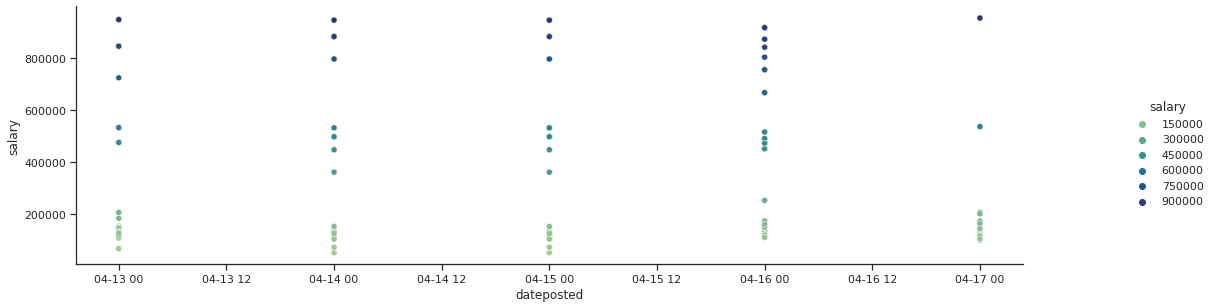

In [77]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [78]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [79]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
iqr_detect(munged)

[947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 945120.0,
 796101.0,
 882112.0,
 945120.0,
 882112.0,
 796101.0,
 945120.0,
 796101.0,
 882112.0,
 796101.0,
 882112.0,
 945120.0,
 796101.0,
 882112.0,
 945120.0,
 796101.0,
 882112.0,
 945120.0,
 882112.0,
 796101.0,
 945120.0,
 796101.0,
 882112.0,
 796101.0,
 882112.0,
 945120.0,
 796101.0,
 882112.0,
 755000.0,
 953121.0,
 916116.0,
 916116.0,
 803102.0,
 755000.0,
 755000.0,
 953121.0,
 916116.0,
 803102.0,
 953121.0,
 916116.0,
 803102.0,
 953121.0,
 916116.0,
 803102.0,
 872110.0,
 916116.0,
 803102.0,
 916116.0,
 803102.0,
 916116.0,
 916116.0,
 803102.0,
 755000.0,
 916116.0,
 841106.0,
 755000.0,
 755000.0,

In [80]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 11 Unique Outliers Are:
945120.0
882112.0
953121.0
796101.0
872110.0
947120.0
841106.0
845107.0
916116.0
755000.0
803102.0
- With a minumum of $755000 and a maximum of $953121


In [81]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,company,location,rating,job_title,text,salary,dateposted,state,city
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
7,eab,"remote in washington, dc 20036",3.7,associate data scientist,"#li-remote about eab at eab, our mission is to...",845107.0,2022-04-13,dc,remote in washington
18,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
22,eab,"remote in washington, dc 20036",3.7,associate data scientist,"#li-remote about eab at eab, our mission is to...",845107.0,2022-04-13,dc,remote in washington
34,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
...,...,...,...,...,...,...,...,...,...
1109,galaxe.solutions,"remote in milwaukee, wi",2.5,data analyst,what you will do:well acquainted with the dba ...,755000.0,2022-04-16,wi,remote in milwaukee
1117,datastream insurance,"remote in philadelphia, pa 19123",0.0,data scientist - remote,about datastream insurance datastream insuranc...,916116.0,2022-04-16,pa,remote in philadelphia
1122,high level,"remote in dallas, tx 75201",0.0,senior data analyst,highlevel is seeking a senior data analyst to ...,803102.0,2022-04-16,tx,remote in dallas
1124,reverb,"remote in chicago, il 60657",0.0,senior marketing data analyst,company description reverb is the largest ...,872110.0,2022-04-16,il,remote in chicago


In [82]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])

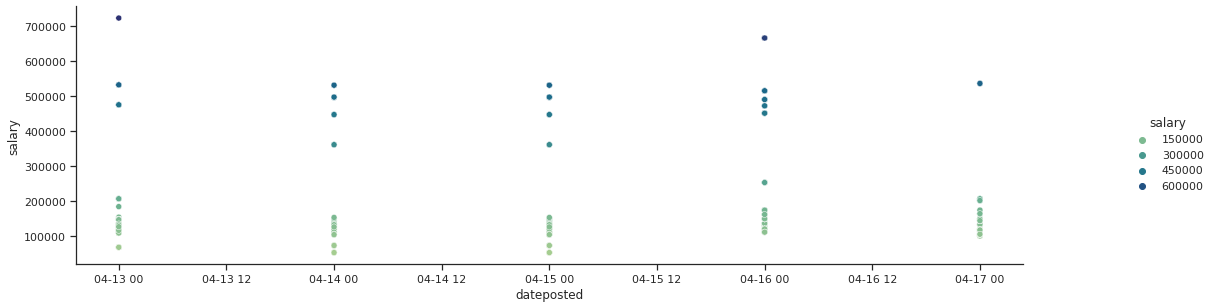

In [83]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

- Dropping 129 outliers now leaves 810, or 78.95%, of rows with with salary information,
- The remaining 216 rows, or 21.05%, are missing salary data.


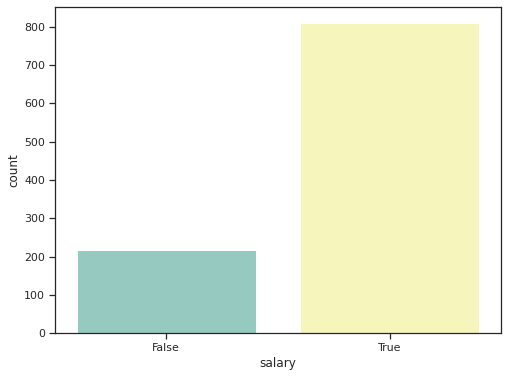

In [84]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [85]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026 entries, 0 to 1154
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   company     1026 non-null   object        
 1   location    1026 non-null   object        
 2   rating      1026 non-null   float64       
 3   job_title   1026 non-null   object        
 4   text        1026 non-null   object        
 5   salary      810 non-null    float64       
 6   dateposted  1026 non-null   datetime64[ns]
 7   state       1026 non-null   object        
 8   city        1026 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 120.2+ KB


In [86]:
munged.to_csv(f'../app/data/munged_data.csv', index=False)